# Probabilistic Autoencoder on LHCO data

## Import machine lerning libraries

In [1]:
import sys
import numpy as np

sys.path.append("../")

from pae.models.autoencoder import DenseAutoencoder
from pae.models.flows import MAF
from pae.models.nn import PaeBuilder

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras as tfk

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


2022-05-06 12:28:42.388107: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-06 12:28:44.013554: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 29018 MB memory:  -> device: 0, name: NVIDIA Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2022-05-06 12:28:44.015204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30989 MB memory:  -> device: 1, name: NVIDIA Tesla V100S-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


In [3]:
from tensorflow.python.client import device_lib

devices = tf.config.list_physical_devices()
print("tensorflow", tf.__version__)
print("tensorflow-probability", tfp.__version__)
print("Available devices:", *[dev[1] for dev in devices])

# SEED = 100
# np.random.seed(SEED) 
# tf.random.set_seed(SEED)

tensorflow 2.8.0
tensorflow-probability 0.16.0
Available devices: CPU GPU GPU


## Plotting libraries 

In [4]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

from plotly.offline import download_plotlyjs, init_notebook_mode
init_notebook_mode(connected = True)
pio.templates.default = "plotly_dark"
pio.templates.default = "presentation"

## Data loading and preprocessing

In [5]:
from pae.utils import load_json, dump_json

from pae.loaders.LHCO import ScalarLoaderLHCO, DatasetBuilder

x = ScalarLoaderLHCO.from_json("../pae/configs/loader/bbox1_scalar_2j.json")
mjj = ScalarLoaderLHCO.from_json("../pae/configs/loader/bbox1_scalar_mjj.json")
builder = DatasetBuilder(x, mjj)
builder.data_preparation(sample_sizes ={'box_s':834, 'box_b': 999166, 'bkg': 500_000}, fit_key='bkg')
dataset = builder.make_dataset(train = {'box_s':834, 'box_b': 999166}, test={'box_s':834, 'box_b': 999166}, replace=True)

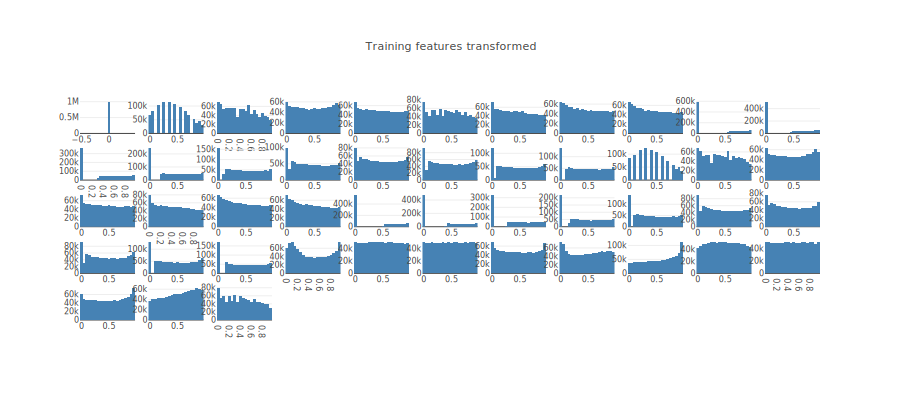

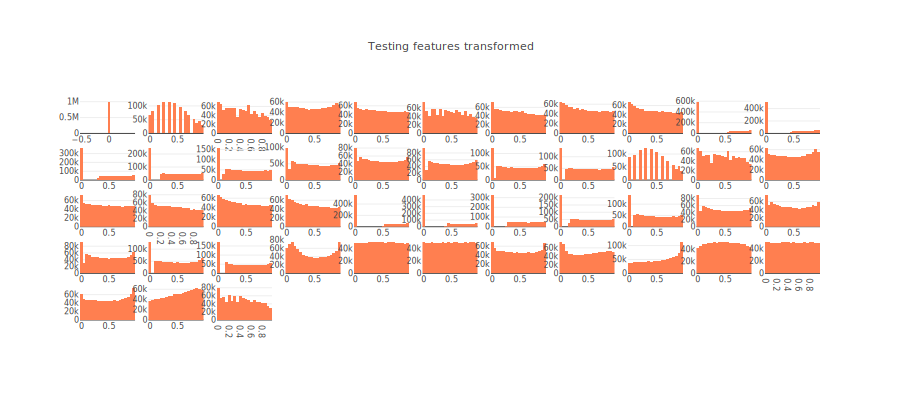

In [6]:
import sys
from pae.plotting import feature_plots
sys.path.append('..')

fig = feature_plots(dataset['x_train'], 'dijet')
fig.update_layout(title="Training features transformed")
fig.show('svg')
fig = feature_plots(dataset['x_test'], 'dijet', color='coral')
fig.update_layout(title="Testing features transformed")
fig.show('svg')

## Density estimation of $m_{jj}$

In [7]:
from pae.density import GMM, ConvKDE, KNNDensity, ExpnormFit

fit_data = dataset["mjj_test"]

# gmm = GMM(n_components=200, covariance_type='full', max_iter=1_000, n_init=5)
# gmm.fit(fit_data)
#y_gmm = gmm.evaluate(fit_data)

fftkde = ConvKDE(bw="silverman", kernel="box")
fftkde.fit(fit_data)
#y_kde = fftkde.evaluate(fit_data)

knn = KNNDensity()
knn.fit(fit_data)
#y_knn = knn.evaluate(fit_data)

# expn = ExpnormFit()
# expn.fit(fit_data)

In [8]:
x_ref = np.arange(1600, 8000)
# y_gmm = gmm.evaluate(x_ref)
y_kde = fftkde.evaluate(x_ref)
y_knn = knn.evaluate(x_ref)
# y_exp = expn.evaluate(x_ref)

$$m_{jj}$$

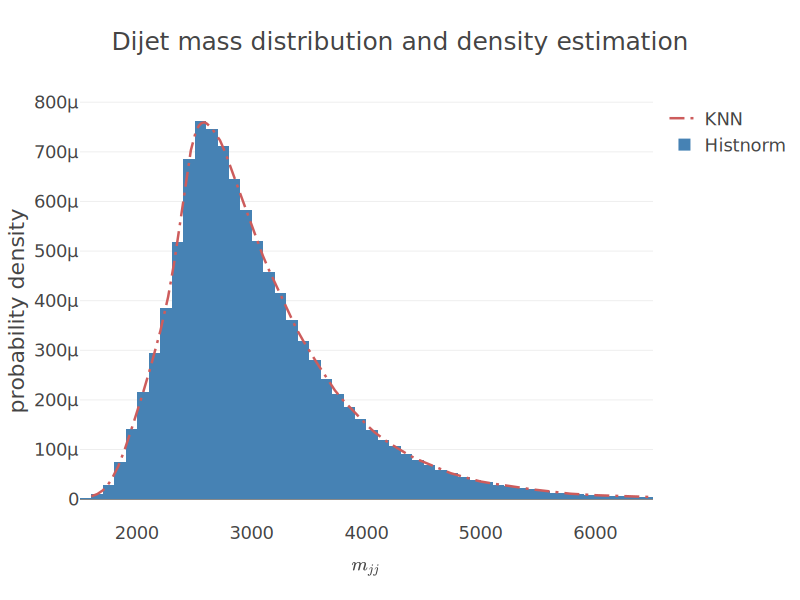

In [9]:
fig = go.Figure()
# fig.add_trace(go.Scatter(x=x_ref, y=y_gmm, mode='lines', name='GMM',
#                          line={'color': 'greenyellow', 'width': 2, 'dash': 'dot'}))
# fig.add_trace(go.Scatter(x=x_ref, y=y_kde, mode='lines', name='FFTKDE',
#                          line={'color': 'turquoise', 'width': 2, 'dash': 'dash'}))
fig.add_trace(go.Scatter(x=x_ref, y=y_knn, mode='lines', name='KNN',
                         line={'color': 'indianred', 'width': 2.5, 'dash': 'longdashdot'}))
# fig.add_trace(go.Scatter(x=x_ref, y=y_exp, mode='lines', name='expnorm',
#                          line={'color': 'indigo', 'width': 2, 'dash': 'solid'}))
fig.add_trace(go.Histogram(x=dataset["mjj_test"].ravel(), nbinsx=100, histnorm='probability density', 
                           marker_color='steelblue', name='Histnorm'))
fig.update_layout(
    title_text='Dijet mass distribution and density estimation',
    xaxis_title_text=r'$$m_{jj}$$',
    yaxis_title_text=r'probability density',
    width=800,
    height=600,
    xaxis_range=[1500,6500]
)
fig.write_image("mjj.pdf")
fig.show('svg')

### Computing Weights

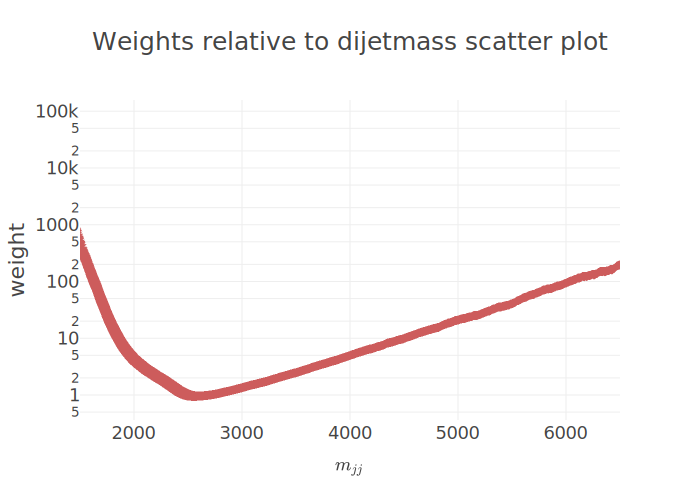

In [10]:
data = dataset['mjj_train'].ravel()

data_key = 'mjj_train'

# w_gmm = gmm.get_weights(dataset[data_key])
w_kde = fftkde.get_weights(dataset[data_key])
# w_expnorm = expn.get_weights(dataset[data_key])
#w_knn = knn.get_weights(dataset[data_key])
fig = go.Figure()
# fig.add_trace(go.Scattergl(x=data, y=w_gmm, 
#                            mode='markers', name='GMM', opacity=0.8,
#                            marker=dict(color='greenyellow',symbol='diamond'))
#             )
# fig.add_trace(go.Scattergl(x=data, y=w_kde, 
#                            mode='markers', name='FFTKDE', opacity=0.8,
#                            marker=dict(color='indianred',symbol='star-square'))
#             )
# fig.add_trace(go.Scattergl(x=data, y=w_expnorm, 
#                            mode='markers', name='expnorm', opacity=0.8,
#                            marker=dict(color='indigo',symbol='circle'))
#             )
fig.add_trace(go.Scattergl(x=data, y=w_kde, 
                           mode='markers', name='KNN', opacity=0.8,
                           marker=dict(color='indianred',symbol='triangle-nw-dot'))
            )
fig.update_layout(
    title_text='Weights relative to dijetmass scatter plot',
    xaxis_title_text=r'$$m_{jj}$$',
    yaxis_title_text=r'weight',
    yaxis_type="log",
    xaxis_range=[1500,6500]
)
fig.write_image("mjj_w.pdf")
fig.show('svg')

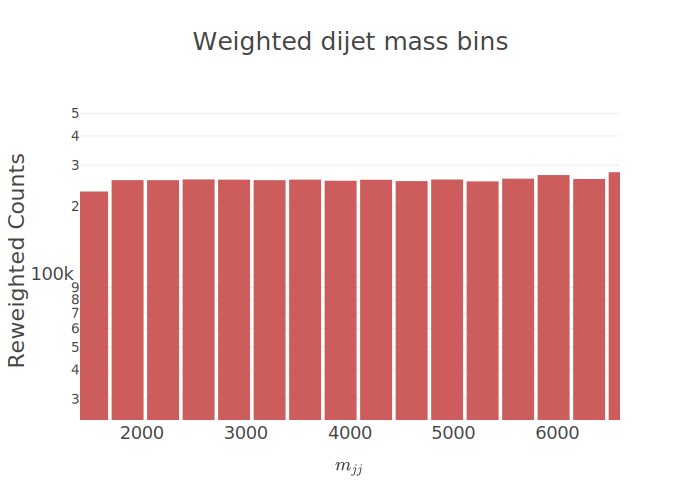

In [11]:
n_kde, b = np.histogram(data, bins=27, weights=w_kde)
# n_gmm, _ = np.histogram(data, bins=b, weights=w_gmm)
# n_exp, _ = np.histogram(data, bins=b, weights=w_expnorm)
# n_knn, _ = np.histogram(data, bins=b, weights=w_knn)
fig = go.Figure()       
fig.add_trace(go.Bar(x=b[:-1], y=n_kde, name='FFTKDE',
                           marker=dict(color='indianred'))
            )
# fig.add_trace(go.Bar(x=b[:-1], y=n_gmm, name='GMM',
#                         marker=dict(color='yellowgreen'))
#             )
# fig.add_trace(go.Bar(x=b[:-1], y=n_exp, name='expnorm',
#                         marker=dict(color='indigo'))
#             )
# fig.add_trace(go.Bar(x=b[:-1], y=n_knn, name='KNN',
#                         marker=dict(color='indianred'))
#             )
fig.update_layout(
    title_text=r'Weighted dijet mass bins',
    xaxis_title_text=r'$$m_{jj}$$',
    yaxis_title_text=r'Reweighted Counts',
    yaxis_type="log",
    bargap=0.1,
    xaxis_range=[1400,6600]
)
fig.write_image("mjj_r.pdf")
fig.show('svg')

## Network creation

In [12]:
# from models import OPTIMIZERS, ACTIVATIONS, REGULARIZERS, MODELS, CALLBACKS
# pae_config = {
#     'ae_model': 'dense_ae',
#     'nf_model': 'maf',
#     'AE:input_dim': 47,
#     'AE:encoding_dim': 10,
#     'AE:units': [30, 20 ,15],
#     'AE:hidden_activation': 'relu',
#     'AE:output_activation': 'sigmoid',
#     'AE:weight_reg': {'l1': 1e-6},
#     'AE:bias_reg': {},
#     'AE:output_reg': {},
#     'NF:n_dims': 10,
#     'NF:n_layers':5, 
#     'NF:units':[32 for i in range(4)]
#     'ae_optimizer': 'adam',
#     'nf_optimizer': 'adam',
#     'ae_optim_kwargs': dict(lr=0.05),
#     'nf_optim_kwargs': dict(lr=0.005),
#     # 'ae_callbacks': ['reduce_lr_on_plateau']
#     # 'ae_callbacks_kwargs': [dict(factor=0.2, patience=10, verbose=1)]
#     # 'nf_callbacks': ['reduce_lr_on_plateau']
#     # 'nf_callbacks_kwargs': [dict(factor=0.2, patience=5, verbose=1)]
# }

In [13]:
builder = PaeBuilder()

ae_config = {
    'input_dim':47, 
    'encoding_dim':12, 
    'units':[30, 20, 15],
    'weight_reg':tfk.regularizers.L1L2(l1=20e-6, l2=20e-5),
    'output_activation':tf.nn.sigmoid
}
nf_config = {
    'n_dims':12, 
    'n_layers':5, 
    'units':[32 for _ in range(4)]
}
optimizer_ae = {
    'learning_rate': 0.001
}
optimizer_nf = {
    'learning_rate': 0.005
}

builder.make_ae_model(DenseAutoencoder, ae_config)
builder.make_ae_optimizer(tfk.optimizers.Adam, optimizer_ae)
builder.make_nf_model(MAF, nf_config)
builder.make_nf_optimizer(tfk.optimizers.Adam, optimizer_nf)
builder.compile_ae()
builder.compile_nf()
pae = builder.pae

In [14]:
from sklearn.model_selection import KFold

fold5 = KFold(8, shuffle=True)
q= fold5.split(dataset["x_train"])
x_train, x_valid = next(q)
print(x_train.shape)
print(x_valid.shape)

(875000,)
(125000,)


In [15]:
#w_kde_valid = fftkde.get_weights(dataset["x_train"][x_valid])
# w_gmm_valid = gmm.get_weights(dataset["x_train"][x_valid])

weights = w_kde

ae_train ={
    'batch_size':200,
    'epochs':120,
    'sample_weight':weights[x_train],
    'validation_data':(dataset["x_train"][x_valid],dataset["x_train"][x_valid], weights[x_valid]),
    'callbacks':tfk.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=10,
        verbose=1
    ),
    "verbose":0
}

nf_train ={
    'batch_size':200,
    'epochs':80,
    'validation_data':(dataset["x_train"][x_valid],dataset["x_train"][x_valid]),
    'callbacks':tfk.callbacks.ReduceLROnPlateau(
        factor=0.2,
        patience=5,
        verbose=1
    ),
    "verbose":0
}
with tf.device("/device:GPU:0"):
    %time pae.fit(dataset["x_train"][x_train],None,ae_train,nf_train)



Epoch 30: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 58: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 73: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 92: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 102: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.

Epoch 112: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.


2022-05-06 13:11:32.946654: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.



Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0001999999862164259.

Epoch 53: ReduceLROnPlateau reducing learning rate to 3.9999996079131965e-05.

Epoch 72: ReduceLROnPlateau reducing learning rate to 7.99999907030724e-06.
CPU times: user 2h 5min 31s, sys: 8min 7s, total: 2h 13min 39s
Wall time: 1h 44min 35s


### Training metrics

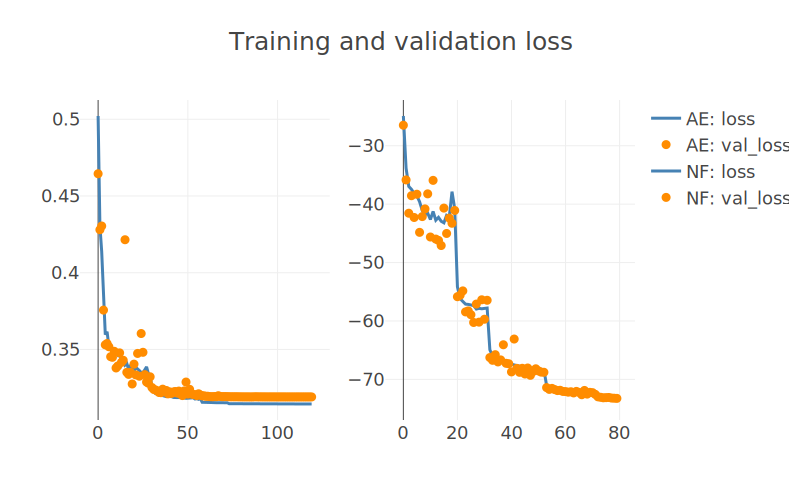

In [16]:
from pae.plotting import loss_plot

fig = loss_plot(pae.history)
fig.show('svg')

In [17]:
# builder = PaeBuilder()
# builder.make_ae_model(DenseAutoencoder, ae_config)
# builder.make_ae_optimizer(tfk.optimizers.Adam, optimizer_ae)
# builder.make_nf_model(MAF, nf_config)
# builder.make_nf_optimizer(tfk.optimizers.Adam, optimizer_nf)
# builder.compile_ae()
# builder.compile_nf()
# pae = builder.pae
# pae.ae(np.zeros(47).reshape(1,-1))
# pae.nf(np.zeros(10).reshape(1,-1))
# pae.ae.load_weights("./save_testing/ae.h5")
# pae.nf.load_weights("./save_testing/nf.h5")

In [18]:
z_true = pae.ae.encode(dataset['x_train'])
z_sample = pae.nf.sample(dataset['x_train'].shape[0])

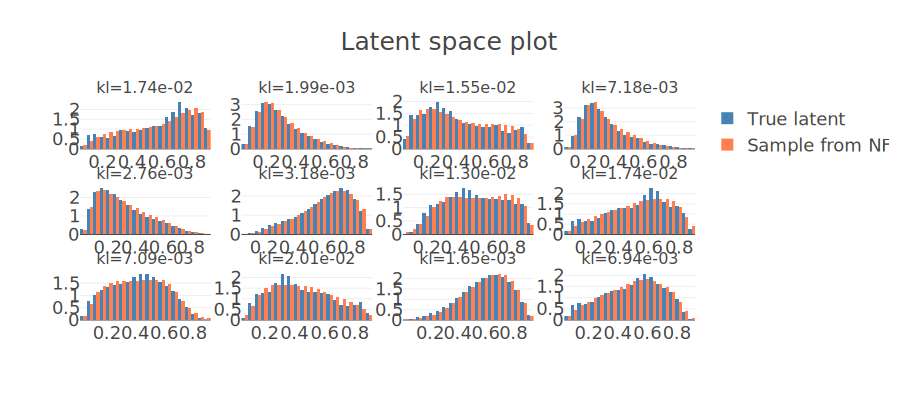

In [19]:
from pae.plotting import latent_space_plot

fig = latent_space_plot(z_true, z_sample)
fig.show('svg')

## Analysis

In [20]:
import tensorflow_probability as tfp
tfd = tfp.distributions
pae.compute_implicit_sigma(dataset['x_train'][x_valid])


In [21]:
mse = pae.reco_error(dataset['x_train'][x_train])
pae.compute_implicit_sigma(dataset['x_train'][x_valid])
ascore = -pae.anomaly_score(dataset['x_train'][x_train])

In [22]:
# test_fractions = {
#     'bkg':100_000,
#     'sig':1000
# }
test2 = dataset#loader.make_test(test_fractions, replace=False)#dataset

ascore = -pae.anomaly_score(test2['x_test'])
mse = pae.reco_error(test2['x_test'])

In [23]:
x=test2['x_test']
mses = np.dot(np.square(pae.ae(x)-x),pae.sigma_square**(-1))
lp = np.exp(np.array(pae.log_prob_encoding(x)))
synergy= -np.sqrt(mse*lp)


/tmp/ipykernel_39315/2738144588.py:3: RuntimeWarning:

overflow encountered in exp



# Load previous result

In [24]:
# mjj = np.fromfile("figures/sig-inj/mjj.npy")
# ascore = np.fromfile("figures/sig-inj/ascore.npy", dtype=np.float32)
# import json

# with open("figures/sig-inj/labels.json", "r") as fp:
#     labels = json.load(fp)

In [25]:
# ascore.tofile("./figures/sig-inj/ascore.npy")
# mjj.tofile("./figures/sig-inj/mjj.npy")

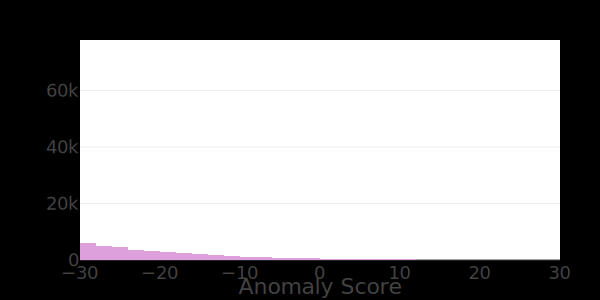

In [26]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
#pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots

prc=50

x_min = np.percentile(ascore, 1)
x_max = np.percentile(ascore, 99)
x_prc = np.percentile(ascore, prc)
i_prc = (ascore >= x_prc)

fig = go.Figure(layout_xaxis_range=[-30,30])
fig.add_trace(go.Histogram(x=ascore, name='Test dataset',
                           marker_color='plum', nbinsx=200),
              )
fig.add_vline(x=x_prc, y1=5100, line_width=2, line_color='firebrick', 
              annotation_text=f"{prc}th percentile", 
              annotation_position="top right",
              )

fig.update_layout(
    xaxis_title='Anomaly Score',
    #title_text=r'Cut on Anomaly Score',
    margin={'l': 80, 'b': 40, 't': 40, 'r': 40},
    width=600, height=300,
    paper_bgcolor='rgba(0,0,0,1)',
        font=dict(size=18))
fig.write_image("./figures/ascore.svg")
fig.show('svg')


$m_{jj}$

In [27]:
# import json

# with open("./figures/sig-inj/labels.json", "w") as fp:
#     json.dump(dict(labels=labels.tolist()),fp)
np.save

<function numpy.save(file, arr, allow_pickle=True, fix_imports=True)>

In [28]:
def adj(x, prc_min=1, prc_max=99):
    xmin, xmax = np.percentile(x,prc_min), np.percentile(x,prc_max)
    return x[(x >= xmin) & (x<= xmax)]

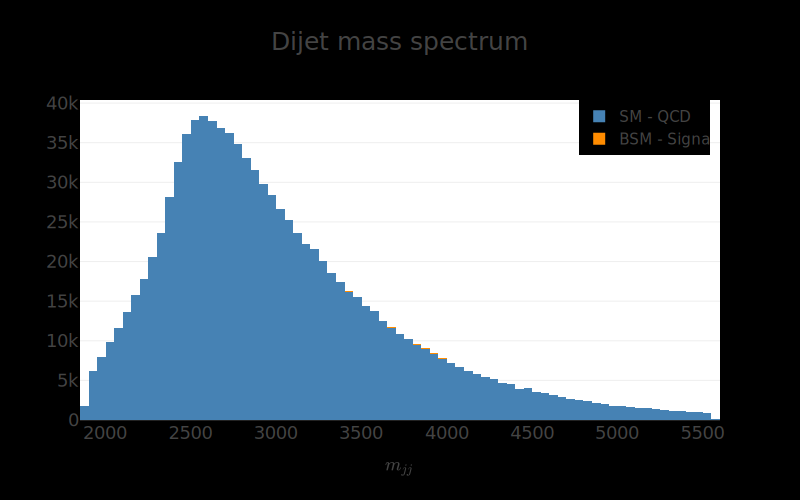

In [29]:
mjj=test2['mjj_test']


def binarize(label):
    return 1 if label == 'box_s' else 0
labels = np.array(list(map(binarize, test2['labels_test'])))
sig_label = (labels==1)
bkg_label = (labels==0)

fig = go.Figure()
fig.add_trace(go.Histogram(x=adj(mjj[bkg_label].ravel()), name="SM - QCD",
                          marker_color='steelblue', nbinsx=150))
fig.add_trace(go.Histogram(x=mjj[sig_label][:2000].ravel(), name="BSM - Signal",
                          marker_color='darkorange'))
sb = 100*sum(sig_label)/sum(bkg_label)
fig.update_layout(
    xaxis_title=r'$m_{jj}$',
    title_text=f'Dijet mass spectrum',
    barmode='stack',
    legend = dict(x=0.78, y=1,
        traceorder='normal',
        font=dict(size=15)),
    paper_bgcolor='rgba(0,0,0,1)',
    width=800, height=500)

fig.show('svg')
fig.write_image("anomaly.pdf") 

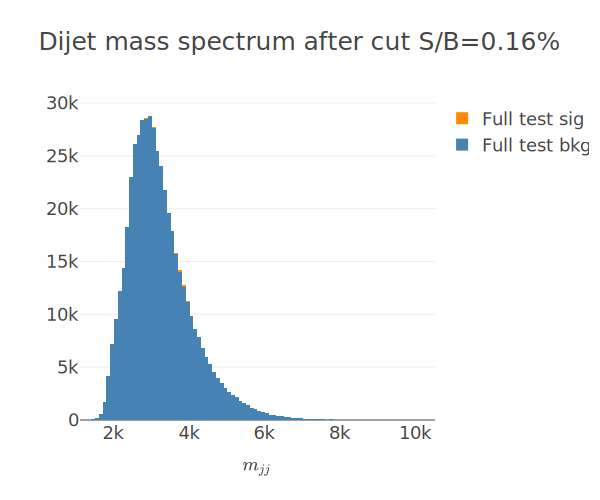

In [30]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=mjj[i_prc&bkg_label].ravel(), name="Full test bkg",
                          marker_color='steelblue', nbinsx=100))
fig.add_trace(go.Histogram(x=mjj[i_prc&sig_label].ravel(), name="Full test sig",
                          marker_color='darkorange'))
sb = 100*sum(i_prc&sig_label)/sum(i_prc&bkg_label)
fig.update_layout(
    xaxis_title='$m_{jj}$',
    title_text=f'Dijet mass spectrum after cut S/B={sb:.2f}%',
    width=600,
    barmode='stack'
    )
fig.show('svg')
fig.write_image("initial.svg") 

/tmp/ipykernel_39315/1720279404.py:8: FutureWarning:

The function <function BumpHunter.__init__ at 0x7f6e2e82f5e0> is deprecated and will be removed in a future release. Use BumpHunter1D or BumpHunter2D instead of BumpHunter.



Generating histograms
4 values of width will be tested
SCAN
Global p-value : 0.0000  (0 / 10000)
Significance > 3.71902 (lower limit)



Text(0.5, 1.0, 'Distributions with bump')

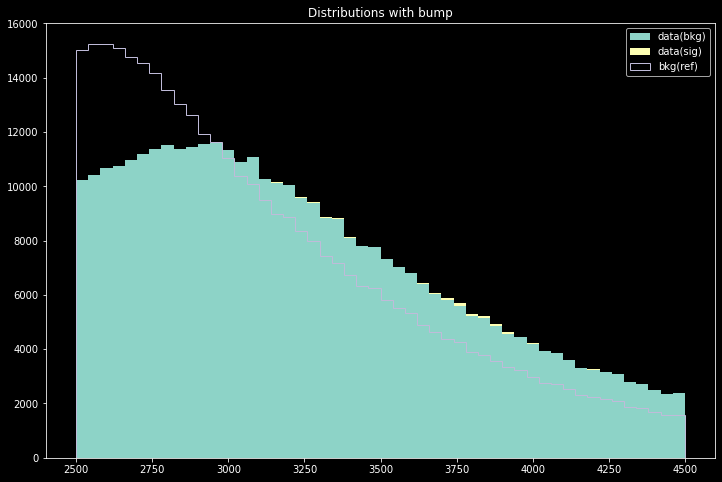

In [31]:
from pyBumpHunter import BumpHunter
import matplotlib.pyplot as plt

bkg = mjj.ravel()
data = mjj[i_prc].ravel()
weights = np.repeat(1/(bkg.shape[0]/data.shape[0]),bkg.shape[0])

hunter = BumpHunter(rang=(2500,4500),
                    width_min=2,
                    width_max=5,
                    width_step=1,
                    scan_step=1,
                    Npe=10000,
                    Nworker=1,
                    seed=666,
                    bins=50,
                    weights=weights,
                    useSideBand = True
                    )

hunter.bump_scan(data,bkg)
hunter.min_loc_ar[0]
b = np.histogram_bin_edges(bkg, range=(2500,4500), bins=50)
fig = plt.figure(figsize=(12,8))
plt.hist([mjj[~sig_label&i_prc].ravel(), mjj[sig_label&i_prc].ravel()], bins=b, range=(2500,4500),
            label=["data(bkg)", "data(sig)"],stacked = True)
plt.hist(bkg, bins=b, range=(2500,4500), label="bkg(ref)",stacked = True, histtype='step', weights=weights)
plt.legend()
plt.title("Distributions with bump")

In [32]:
hunter.print_bump_true(data,bkg)

BUMP POSITION
   min : 3500.000
   max : 3660.000
   mean : 3580.000
   width : 160.000
   number of signal events : 5748.650430730566
   global p-value : 0.00000
   global significance = 3.71902



/tmp/ipykernel_39315/3713536587.py:1: FutureWarning:

The function <function BumpHunter1D.print_bump_true at 0x7f6e267f7670> is deprecated and will be removed in a future release. Use `bump_info` instead.



In [33]:
print("Eff:",mjj[i_prc&sig_label].shape[0]/1000)
print("Rej:",1-mjj[i_prc&bkg_label].shape[0]/200_000)

Eff: 0.792
Rej: -1.4960399999999998


In [34]:
ascore = -pae.anomaly_score(dataset['x_test'])
mse = pae.reco_error(dataset['x_test'])
x=dataset['x_test']
mses = np.dot(np.square(pae.ae(x)-x),pae.sigma_square**(-1))
lp = np.exp(np.array(pae.log_prob_encoding(x)))


# CLCULATE TEST MAP
tfd = tfp.distributions

sigma = tf.constant(tf.sqrt(pae.sigma_square))
BATCH_SIZE_MAP = np.min([10_000, dataset['x_test'].shape[0]//10])
z_ = tf.Variable(pae.ae.encoder(dataset['x_test'][:BATCH_SIZE_MAP].astype(np.float32))) #tf.Variable(pae.ae.encoder(dataset['x_test']))
opt = tf.optimizers.Adam(learning_rate=0.001)
STEPS=500


@tf.function
def max_apriori_prob(x, z, sigma, pae):
    distrs = tfd.MultivariateNormalDiag(loc=x, scale_diag=sigma)
    nf_ll = pae.nf(z)
    reco = pae.ae.decoder(z)
    gauss_ll = distrs.log_prob(reco)
    return  tf.reduce_mean(-nf_ll - gauss_ll) 


@tf.function
def find_map(x_):
    global z_
    if z_ is None:
        z_ = tf.Variable(pae.ae.encoder(x_))
    z_.assign(pae.ae.encoder(x_))
    for _ in range(STEPS):
        with tf.GradientTape() as tape:
            tape.watch(z_)
            nll = max_apriori_prob(x_, z_, sigma, pae)
        grad = tape.gradient(nll, [z_])
        opt.apply_gradients(zip(grad, [z_]))
    return z_

ds_ = tf.convert_to_tensor(dataset['x_test'], dtype=tf.float32)
ds = tf.data.Dataset.from_tensor_slices(ds_)
ds = ds.cache()
ds = ds.batch(BATCH_SIZE_MAP)
ds = ds.prefetch(BATCH_SIZE_MAP)

#tf.profiler.experimental.start(str(run_dir / "map"))
with tf.device("/device:GPU:0"):
#with tf.device("/device:CPU:0"):
    ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=True)
    for i, batch in enumerate(ds):
        ta = ta.write(i, find_map(batch))
    z_map = ta.concat()
    del ta
#tf.profiler.experimental.stop()

with tf.device("/device:GPU:0"):
    byz = pae.nf.inverse(z_map)
    detJ = pae.nf.inverse_log_det_jacobian(z_map)
    x = pae.ae.decode(z_map)
    reco_error = np.square(x-dataset['x_test'])
    ascore2 = +0.5*np.dot(reco_error,pae.sigma_square**(-1)) + \
            0.5*np.linalg.norm(byz,axis=1)**2 - detJ
    lp2 = -pae.nf(z_map)
    mse2 = np.mean(reco_error, axis=1)
    mses2 = np.dot(reco_error,pae.sigma_square**(-1))

/tmp/ipykernel_39315/1945895084.py:5: RuntimeWarning:

overflow encountered in exp



Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Generating histograms
4 values of width will be tested
SCAN
Global p-value : 0.0000  (0 / 10000)
Significance > 3.71902 (lower limit)



Text(0.5, 1.0, 'Distributions with bump')

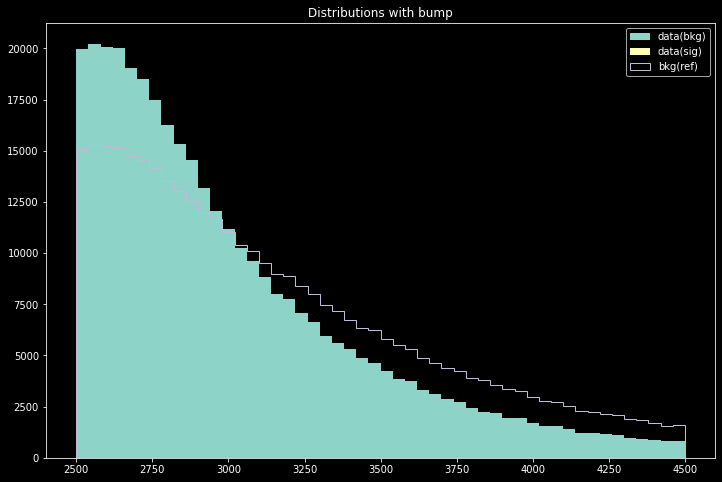

In [35]:
x_min2 = np.percentile(ascore2, 1)
x_max2 = np.percentile(ascore2, 99)
x_prc2 = np.percentile(ascore2, prc)
i_prc2 = (ascore2 >= x_prc2)

#bump 2
bkg = mjj.ravel()
data = mjj[i_prc2].ravel()
weights = np.repeat(1/(bkg.shape[0]/data.shape[0]),bkg.shape[0])

hunter = BumpHunter(rang=(2500,4500),
                    width_min=2,
                    width_max=5,
                    width_step=1,
                    scan_step=1,
                    Npe=10000,
                    Nworker=1,
                    seed=666,
                    bins=50,
                    weights=weights,
                    useSideBand = True
                    )

hunter.bump_scan(data,bkg)
hunter.min_loc_ar[0]
b = np.histogram_bin_edges(bkg, range=(2500,4500), bins=50)
fig = plt.figure(figsize=(12,8))
plt.hist([mjj[~sig_label&i_prc2].ravel(), mjj[sig_label&i_prc2].ravel()], bins=b, range=(2500,4500),
            label=["data(bkg)", "data(sig)"],stacked = True)
plt.hist(bkg, bins=b, range=(2500,4500), label="bkg(ref)",stacked = True, histtype='step', weights=weights)
plt.legend()
plt.title("Distributions with bump")

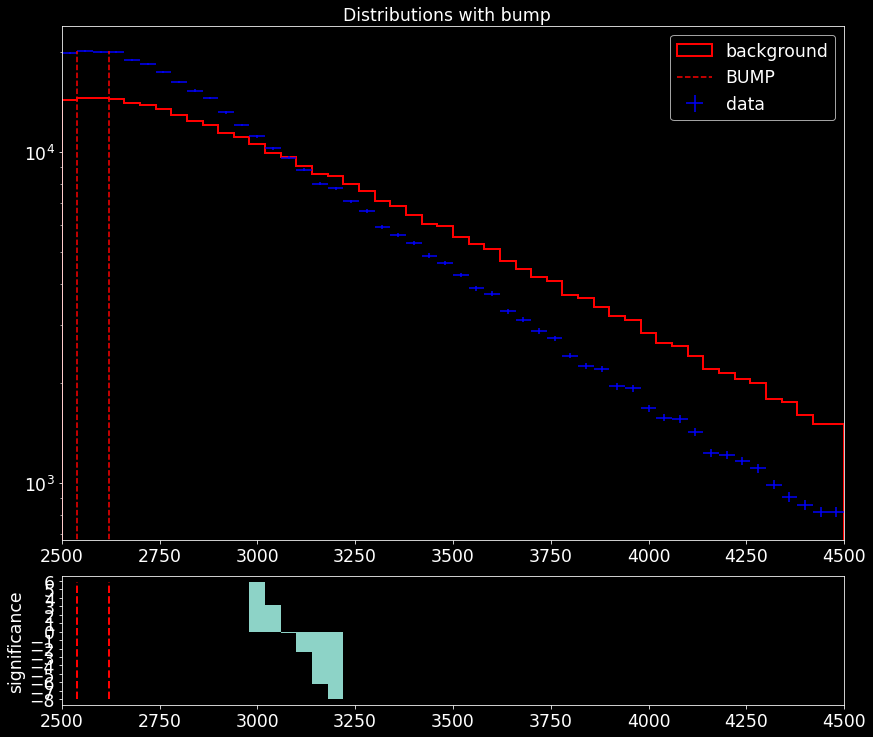

In [36]:
hunter.plot_bump(data,bkg)

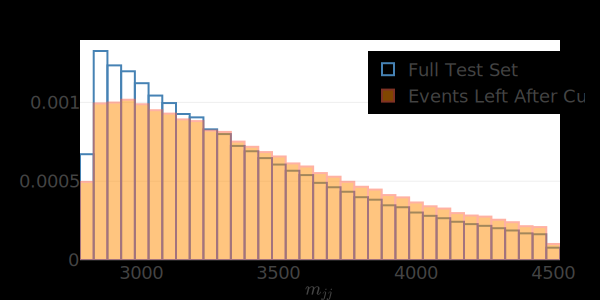

In [37]:
inrange = (mjj >= 2800) & (mjj <=4500)
fig = go.Figure()
fig.add_trace(go.Histogram(x=mjj[inrange].ravel(), name="Full Test Set", histnorm='probability density',
                          nbinsx=40, bingroup='1',
                          marker=dict(color='rgba(135, 206, 250, 0.0)', 
                                  line=dict(
                                        color='SteelBlue',
                                        width=2
            ))))
fig.add_trace(go.Histogram(x=mjj[inrange.ravel()&i_prc].ravel(), name="Events Left After Cut", opacity=0.5, nbinsx=40,
                          marker_color='darkorange', bingroup='1', histnorm='probability density',
                          marker=dict(line=dict(
                                        color='Tomato',
                                        width=2
            ))))
#sb = 100*sum(i_prc&sig_label)/sum(i_prc&bkg_label)
fig.update_layout(
    xaxis_title='$$m_{jj}$$',
    #title_text=f'Dijet mass spectra',
    margin={'l': 80, 'b': 40, 't': 40, 'r': 40},
    width=600, height=300,
    paper_bgcolor='rgba(0,0,0,1)',
        font=dict(size=18),
    barmode='overlay',
    legend = dict(x=0.6, y=0.95,
        traceorder='normal',
        font=dict(size=18)),
    )
fig.write_image("./figures/mjj_demo.svg")
fig.show('svg') 

In [38]:
bkg = mjj.ravel()
data = mjj[i_prc].ravel()
weights = np.repeat(1/(bkg.shape[0]/data.shape[0]),bkg.shape[0])
#weights_k = np.repeat(1/(data.shape[0]/data2.shape[0]),data.shape[0])

In [39]:
from pyBumpHunter import BumpHunter

hunter = BumpHunter(rang=(3000,4000),
                       width_min=2,
                       width_max=5,
                       width_step=1,
                       scan_step=1,
                       Npe=10000,
                       Nworker=1,
                       seed=666,
                       bins=50,
                       weights=weights,
                       useSideBand = True
                    )

# x_prc_50 = np.percentile(ascore_test, 50)

# high_prc = np.where(ascore_test >= x_prc_50)
# low_prc = np.where(ascore_test <= x_prc_50)

# data, bkg = test2['excl_test'][high_prc][:,0], test2['excl_test'][low_prc][:,0]

%time hunter.bump_scan(data,bkg)

Generating histograms
4 values of width will be tested
SCAN
Global p-value : 0.0000  (0 / 10000)
Significance > 3.71902 (lower limit)

CPU times: user 13.9 s, sys: 2.27 s, total: 16.2 s
Wall time: 13.9 s


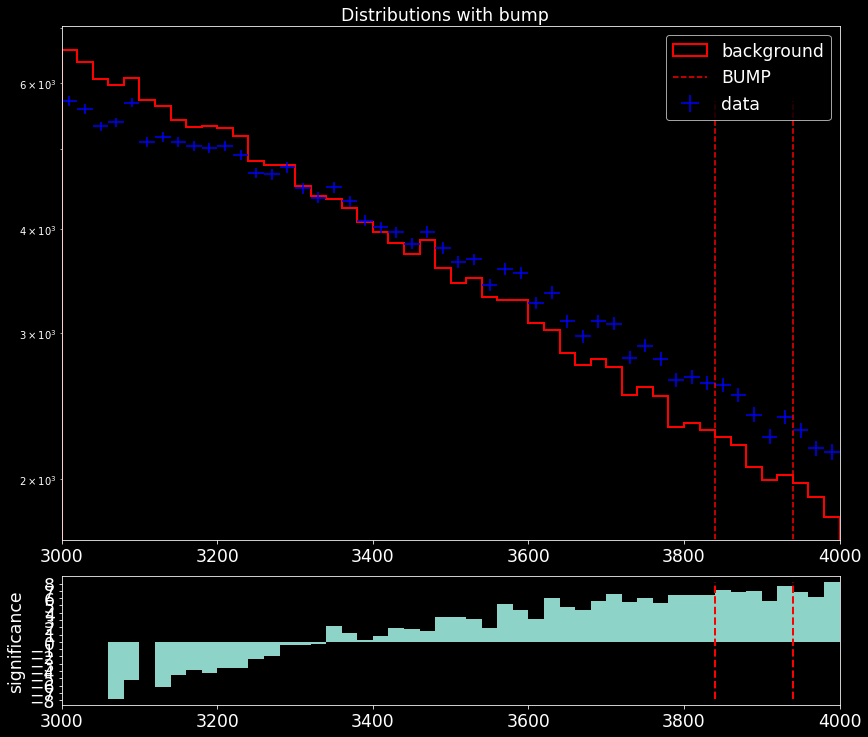

In [40]:
hunter.plot_bump(data,bkg)

In [41]:
hunter.print_bump_true(data,bkg)

BUMP POSITION
   min : 3840.000
   max : 3940.000
   mean : 3890.000
   width : 100.000
   number of signal events : 1610.2640235776707
   global p-value : 0.00000
   global significance = 3.71902



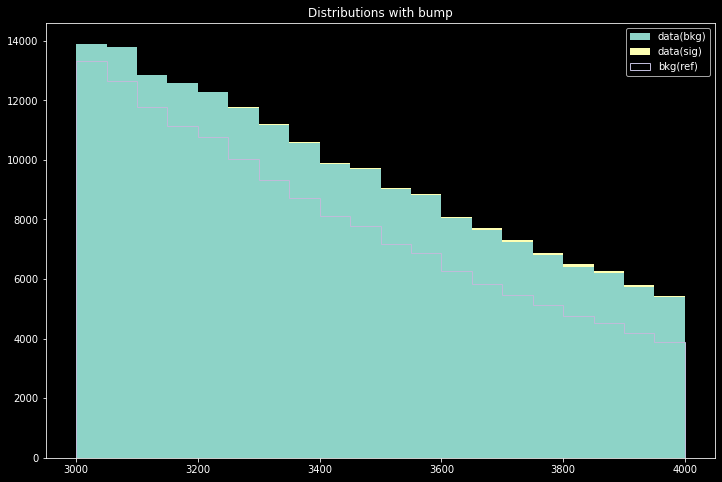

In [42]:
import matplotlib.pyplot as plt

sig_mask = sig_label

hunter.min_loc_ar[0]
b = np.histogram_bin_edges(bkg, range=(3000,4000), bins=20)
fig = plt.figure(figsize=(12,8))
plt.hist([mjj[~sig_mask&i_prc].ravel(), mjj[sig_mask&i_prc].ravel()], bins=b, range=(3000,4000),label=["data(bkg)", "data(sig)"],stacked = True)
plt.hist(bkg, bins=b, range=(3000,4000), label="bkg(ref)",stacked = True, histtype='step', weights=weights)
plt.legend()
# line = plt.axvline(x=3520.000, color='red', linestyle="--")
# line.set_label('Label via method')
# plt.axvline(x=3580.000, color='red', linestyle="--")
plt.title("Distributions with bump")
plt.show()

## Plots

In [43]:
from scipy.spatial.distance import jensenshannon

def mass_sculpting(mjj, score):
    max_prc = 99
    n_full, b = np.histogram(mjj, bins=60, density=True)
    js_div = {}
    for prc in range(1, max_prc+1):
        x_prc = np.percentile(score, prc)
        i_prc = np.where(score >= x_prc)[0]
        n_prc, _ = np.histogram(mjj[i_prc], bins=b, density=True)
        js_div[prc] = jensenshannon(n_full,n_prc)

    return js_div

def nmse(x, pae):
    reco_error = np.square(pae.ae(x)-x)
    return np.dot(reco_error,pae.sigma_square**(-1))


In [44]:
js_div_nf = load_json("./nf-js.json")

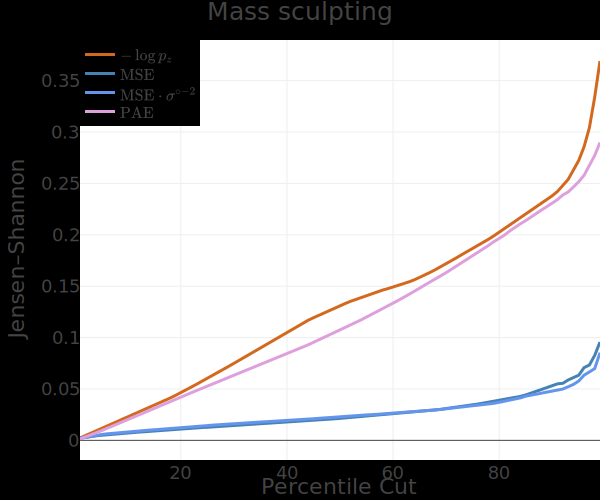

In [45]:
from scipy.spatial.distance import jensenshannon
#pio.templates.default = "plotly_dark"
mjj = dataset['mjj_test']

score = pae.anomaly_score(dataset['x_test'])
js_div_pae = mass_sculpting(mjj,score)

score = nmse(dataset['x_test'], pae)
js_div_nmse = mass_sculpting(mjj,score)

score = pae.reco_error(dataset['x_test'])
js_div_mse = mass_sculpting(mjj,score)

score = -pae.log_prob_encoding(dataset['x_test'])
js_div_lpz = mass_sculpting(mjj,score)

fig = go.Figure()
# fig.add_shape(
#     type='line', line=dict(dash='dash', color="tomato", width=1),
#     x0=90, x1=90, y0=0, y1=0.04, 
# )

fig.add_trace(
    go.Scatter(x=list(js_div_pae.keys()), y=list(js_div_lpz.values()), mode='lines',
        name=r"$-\log p_z$", line=dict(color="chocolate", width=3))
)
fig.add_trace(
    go.Scatter(x=list(js_div_pae.keys()), y=list(js_div_mse.values()), mode='lines',
        name=r"$\text{MSE}$", line=dict(color="steelblue", width=3))
)
fig.add_trace(
    go.Scatter(x=list(js_div_pae.keys()), y=list(js_div_nmse.values()), mode='lines',
        name=r"$\text{MSE} \cdot \sigma^{\circ-2}$", line=dict(color="cornflowerblue", width=3))
)
fig.add_trace(
    go.Scatter(x=list(js_div_pae.keys()), y=list(js_div_pae.values()), mode='lines',
        name=r"$\text{PAE}$", line=dict(color="plum", width=3))
)



# fig.add_trace(go.Scatter(
#     x=[86],
#     y=[0.003],
#     mode="text",
#     text=["97th percentile"],
#     textposition="top center",
#     showlegend=False
# ))

fig.update_layout(
    title_text = "Mass sculpting",
    xaxis_title = "Percentile Cut",
    yaxis_title = "Jensen–Shannon",
    margin={'l': 80, 'b': 40, 't': 40, 'r': 0},
    width=600, height=500,
    paper_bgcolor='rgba(0,0,0,1)',
        legend = dict(x=0, y=1,
        traceorder='normal',
        font=dict(size=15))
)
fig.show('svg')
fig.write_image("JS-plot.pdf")


In [46]:
def make_trace(labels, score, c, n=""):
    fpr, tpr, _ = roc_curve(labels, score)
    aauc = auc(1-fpr, tpr)
    print(n,aauc)
    return go.Scatter(x=tpr, y=1-fpr, mode='lines',
        name=n+f"AUC:{aauc:.2f}", line=dict(color=c, width=2))

nf_roc = load_json("./nf-roc.json")

 0.5801623614046152
 0.5945693906559797
 0.8843480312700696


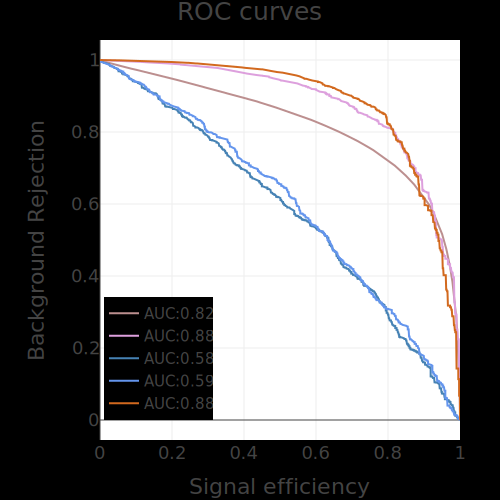

In [47]:
from sklearn.metrics import roc_curve, auc
import plotly.express as px

def binarize(label):
    return 1 if label == 'box_s' else 0
labels = np.array(list(map(binarize, test2['labels_test'])))

fpr, tpr, _ = roc_curve(labels, ascore)
pae_auc = auc(1-fpr, tpr)

score = pae.reco_error(dataset['x_test'])
roc_mse = make_trace(labels, score, 'steelblue')

score = nmse(dataset['x_test'], pae)
roc_nmse = make_trace(labels, score, 'cornflowerblue')

score = -pae.log_prob_encoding(dataset['x_test'])
roc_lpz = make_trace(labels, score, 'chocolate')

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=nf_roc["eff"], y=nf_roc["rej"], mode='lines',
        name=f"AUC:{nf_roc['auc']:.2f}", line=dict(color="rosybrown", width=2))
)

fig.add_trace(
    go.Scatter(x=tpr, y=1-fpr, mode='lines',
        name=f"AUC:{pae_auc:.2f}", line=dict(color="Plum", width=2))
)

fig.add_trace(roc_mse)
fig.add_trace(roc_nmse)
fig.add_trace(roc_lpz)
fig.update_layout(
    width=500, height=500,
    xaxis_title = "Signal efficiency",
    yaxis_title = "Background Rejection",
    margin={'l': 60, 'b': 60, 't': 40, 'r': 0},
    legend = dict(x=0.1, y=0.05,
        traceorder='normal',
        font=dict(size=15)),
    title_text="ROC curves",
    showlegend=True,
    paper_bgcolor='rgba(0,0,0,1)',
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.write_image("ROC2jet.pdf")
fig.show("svg")

In [48]:
def make_trace2(labels, score, c, n=""):
    fpr, tpr, _ = roc_curve(labels, score)
    aauc = auc(1-fpr, tpr)
    print(n,aauc)
    return go.Scatter(x=tpr, y=1-fpr, mode='lines',
        name=n+f"AUC:{aauc:.2f}", line=dict(color=c, width=2)), 1-fpr, tpr, aauc

roc_lpz2, fpr, tpr, a = make_trace2(labels, lp2, 'coral')
roc_pae2, fpr, tpr, a = make_trace2(labels, ascore2, 'indigo')
roc_mse2, fpr, tpr, a = make_trace2(labels, mse2, 'royalblue')
roc_nmse2, fpr, tpr, a = make_trace2(labels, mses2, 'deepskyblue')

fig = go.Figure()
fig.add_trace(roc_lpz2)
fig.add_trace(roc_mse2)
fig.add_trace(roc_nmse2)
fig.add_trace(roc_pae2)
fig.update_layout(
    width=500, height=500,
    xaxis_title = "Signal efficiency",
    yaxis_title = "Background Rejection",
    margin={'l': 60, 'b': 60, 't': 40, 'r': 0},
    legend = dict(x=0.1, y=0.05,
        traceorder='normal',
        font=dict(size=15)),
    title_text="ROC curves",
    showlegend=True,
    paper_bgcolor='rgba(0,0,0,1)',
)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

 0.3809378886499734
 0.3917510945135438
 0.5811753921235538
 0.595637544685889
